In [1]:
import warnings
warnings.filterwarnings('ignore')

# import preprocessing function
from helpers.preprocessing import *

# import dependencies
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
from config import db_password
import matplotlib.pyplot as plt

# import machine learning dependencies
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import multiprocessing

# import neural network dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics

## Read the Data from SQL

In [2]:
X, y = preprocessing('fall')
X.head()

,accommodates,longitude,latitude,availability_90,minimum_nights,host_listings_count,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,bathrooms,property_Camper/RV,property_Entire Home,property_Entire Unit,property_Other,property_Private room,property_Shared room
0,8,-117.25760,32.80751,6,4,5.0,4.76,4.75,4.55,4.91,4.91,4.80,4.76,2.0,0,1,0,0,0,0
1,1,-117.21931,32.74217,54,1,3.0,4.33,4.35,4.22,4.72,4.79,4.61,4.40,1.0,0,0,0,0,1,0
2,7,-117.25416,32.79783,0,6,2.0,4.75,4.79,4.55,4.88,4.81,4.89,4.69,2.5,0,1,0,0,0,0
3,8,-117.25728,32.80751,44,6,2.0,4.72,4.77,4.73,4.88,4.81,4.78,4.65,2.0,0,1,0,0,0,0
4,3,-117.26856,32.81301,42,5,2.0,4.94,4.92,4.95,4.97,4.98,4.97,4.89,1.0,0,1,0,0,0,0


In [3]:
log_y = np.log10(y)
log_y.describe()

count    14109.000000
mean         2.298119
std          0.351525
min          1.000000
25%          2.071882
50%          2.269513
75%          2.511883
max          3.698970
Name: price, dtype: float64

# Split the Data into Training and Testing

In [4]:
X.describe()

,accommodates,longitude,latitude,availability_90,minimum_nights,host_listings_count,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,bathrooms,property_Camper/RV,property_Entire Home,property_Entire Unit,property_Other,property_Private room,property_Shared room
count,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000,14109.000000
mean,4.847686,-117.173729,32.763446,49.081012,6.714863,53.551917,4.749562,4.797682,4.757463,4.859802,4.843776,4.831948,4.691706,1.598554,0.006166,0.405840,0.419307,0.002977,0.160111,0.005599
std,3.138492,0.074982,0.096052,31.436905,19.284519,210.275962,0.388858,0.338013,0.357554,0.305637,0.322197,0.286189,0.365933,0.976409,0.078286,0.491071,0.493463,0.054481,0.366722,0.074621
min,1.000000,-117.282580,32.519860,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,-117.248900,32.718920,20.000000,1.000000,1.000000,4.710000,4.790000,4.720000,4.860000,4.840000,4.820000,4.640000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,-117.166590,32.756490,56.000000,2.000000,4.000000,4.820000,4.870000,4.830000,4.940000,4.930000,4.900000,4.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,-117.129000,32.798990,77.000000,4.000000,18.000000,4.950000,4.980000,4.960000,5.000000,5.000000,5.000000,4.890000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,16.000000,-116.896560,33.125690,90.000000,999.000000,2641.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,27.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, log_y, random_state=10)

In [6]:
y_train.describe()

count    10581.000000
mean         2.297627
std          0.351435
min          1.000000
25%          2.071882
50%          2.269513
75%          2.511883
max          3.698970
Name: price, dtype: float64

In [7]:
y_test.describe()

count    3528.000000
mean        2.299596
std         0.351840
min         1.176091
25%         2.068186
50%         2.274158
75%         2.511883
max         3.673297
Name: price, dtype: float64

In [8]:
# scale the X data
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## XGBoost Model

In [9]:
# create a XGBooster regression model and use GridSearch to test various fits
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[10:57:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[10:57:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                               

In [10]:
# show results of best model in grid
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.7844518099239091
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [11]:
# use xgb_grid model to predict prices for testing and training groups
pred_test = xgb_grid.best_estimator_.predict(X_test)
pred_train = xgb_grid.best_estimator_.predict(X_train)

# mean squared error isn't meaningful with logarithmic data
print("\nTraining MSE:", round(mean_squared_error(10**y_train, 10**pred_train),4))
print("Testing MSE:", round(mean_squared_error(10**y_test, 10**pred_test),4))

# mean absolute error as sqrt of MSE
print("\nTraining MAE:", round(mean_squared_error(10**y_train, 10**pred_train)**0.5,4))
print("Testing MAE:", round(mean_squared_error(10**y_test, 10**pred_test)**0.5,4))

# print r2 values for training and testing models
print("\nTraining r2:", round(r2_score(y_train, pred_train),4))
print("Testing r2:", round(r2_score(y_test, pred_test),4))


Training MSE: 16470.7346
Testing MSE: 40650.9661

Training MAE: 128.3384
Testing MAE: 201.6208

Training r2: 0.913
Testing r2: 0.8006


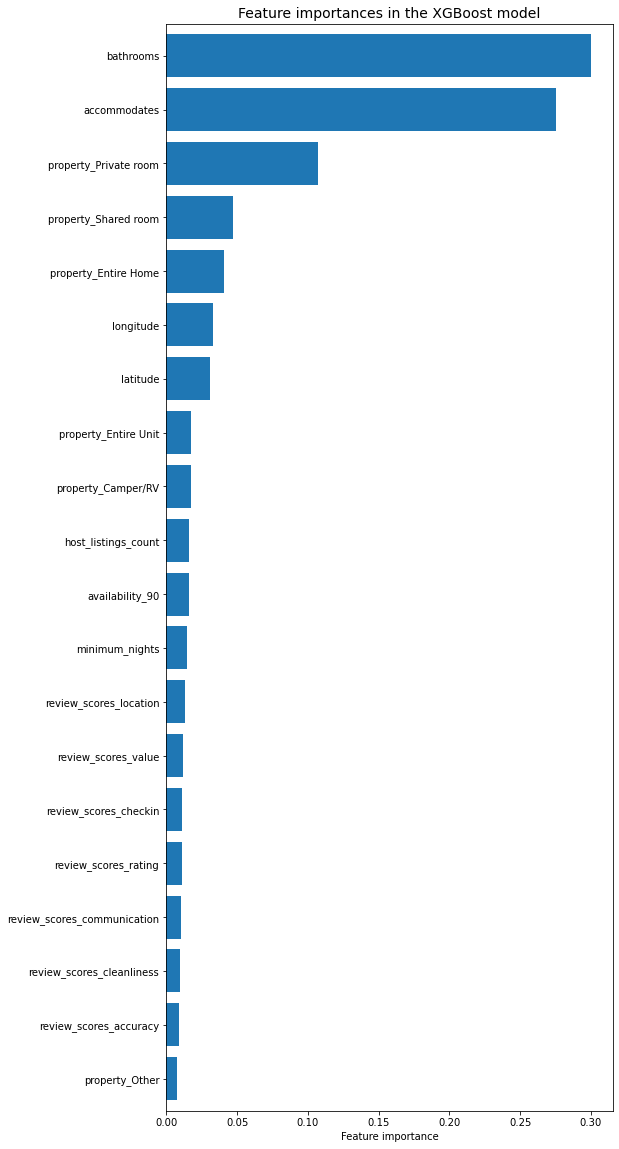

In [12]:
# plot the importance of features in the xgb_grid model
ft_weights_xgb_grid = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_grid.sort_values('weight', inplace=True)

plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_grid.index, ft_weights_xgb_grid.weight, align='center')
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [13]:
# a simpler XGBooster model, without the grid search

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_training_preds = xgb_model.predict(X_train)
xgb_test_preds = xgb_model.predict(X_test)

In [14]:
# print the r2 scores for the simple xgb_model
print("\nTraining r2:", round(r2_score(y_train, xgb_training_preds),4))
print("Testing r2:", round(r2_score(y_test, xgb_test_preds),4))


Training r2: 0.9291
Testing r2: 0.7875


## Neural Network

In [15]:
X_train_scaled.shape

(10581, 20)

In [24]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = X_train_scaled.shape[1]
hidden_nodes_layer1 = 60
hidden_nodes_layer2 = 180
hidden_nodes_layer3 = 180

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 60)                1260      
                                                                 
 dense_9 (Dense)             (None, 180)               10980     
                                                                 
 dense_10 (Dense)            (None, 180)               32580     
                                                                 
 dense_11 (Dense)            (None, 1)                 181       
                                                                 
Total params: 45,001
Trainable params: 45,001
Non-trainable params: 0
_________________________________________________________________


In [25]:
nn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics = ['mean_squared_error'])

In [26]:
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
331/331 [==============================] - 3s 4ms/step - loss: 1.3915 - mean_squared_error: 416.1009
Epoch 2/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2798 - mean_squared_error: 0.1295
Epoch 3/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2800 - mean_squared_error: 0.1296
Epoch 4/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2777 - mean_squared_error: 0.1278
Epoch 5/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2778 - mean_squared_error: 0.1277
Epoch 6/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2768 - mean_squared_error: 0.1273
Epoch 7/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2763 - mean_squared_error: 0.1266
Epoch 8/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2773 - mean_squared_error: 0.1274
Epoch 9/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2770 - mean_squared_error: 0.1272

331/331 [==============================] - 1s 4ms/step - loss: 0.2801 - mean_squared_error: 0.1292
Epoch 75/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2773 - mean_squared_error: 0.1270
Epoch 76/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2766 - mean_squared_error: 0.1265
Epoch 77/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2772 - mean_squared_error: 0.1271
Epoch 78/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2767 - mean_squared_error: 0.1265
Epoch 79/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2762 - mean_squared_error: 0.1266
Epoch 80/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2767 - mean_squared_error: 0.1266
Epoch 81/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2781 - mean_squared_error: 0.1277
Epoch 82/100
331/331 [==============================] - 1s 4ms/step - loss: 0.2764 - mean_squared_error: 0.1269
Epoch

In [23]:
# Evaluate the mean absolute error of the  model using the test data
nn_train_preds = nn.predict(X_train_scaled)
nn_test_preds = nn.predict(X_test_scaled)

print("\nTraining MSE:", round(mean_squared_error(10**y_train, 10**nn_train_preds),4))
print("Testing MSE:", round(mean_squared_error(10**y_test, 10**nn_test_preds),4))

print("\nTraining MAE:", round(mean_squared_error(10**y_train, 10**nn_train_preds)**0.5,4))
print("Testing MAE:", round(mean_squared_error(10**y_test, 10**nn_test_preds)**0.5,4))

print("\nTraining r2:", round(r2_score(y_train, nn_train_preds),4))
print("Testing r2:", round(r2_score(y_test, nn_test_preds),4))

111/111 [==============================] - 0s 3ms/step

Training MSE: 115538.846
Testing MSE: 121704.6563

Training MAE: 339.9101
Testing MAE: 348.8619

Training r2: -0.0045
Testing r2: -0.0053
